In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
# from tqdm import tqdm_notebook 
from tqdm import tqdm

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

In [2]:
from scipy.special import expit
class SigmoidNeuron:
    
  def __init__(self):
    self.w = None
    self.b = None

  def perceptron(self, x):
    return np.dot(x, self.w.T) + self.b

  def sigmoid(self, x):
    #return 1.0/(1.0 + np.exp(-x))
    return expit(x)

  def grad_w_mse(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred) * x

  def grad_b_mse(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    return (y_pred - y) * y_pred * (1 - y_pred)

  def grad_w_ce(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    if y == 0:
      return y_pred * x
    elif y == 1:
      return -1 * (1 - y_pred) * x
    else:
      raise ValueError("y should be 0 or 1")

  def grad_b_ce(self, x, y):
    y_pred = self.sigmoid(self.perceptron(x))
    if y == 0:
      return y_pred 
    elif y == 1:
      return -1 * (1 - y_pred)
    else:
      raise ValueError("y should be 0 or 1")

  def fit(self, X, Y, epochs=1, gamma=0.9, learning_rate=1, initialise=True,algo="GD",mini_batch_size=100, loss_fn="mse", display_loss=False):
    
    
    # initialise w, b
    if initialise:
      self.w = np.random.randn(1, X.shape[1])
      self.b = 0

    if display_loss:
      loss = {}
    
    prevUpdateW = 0
    prevUpdateB = 0
    for i in tqdm(range(epochs), total=epochs, unit="epoch"):
        dw = 0
        db = 0
        
        if algo =="GD":
            for x, y in zip(X, Y):
                if loss_fn == "mse":
                    dw += self.grad_w_mse(x, y)
                    db += self.grad_b_mse(x, y) 
                elif loss_fn == "ce":
                    dw += self.grad_w_ce(x, y)
                    db += self.grad_b_ce(x, y)

            m = X.shape[1]  
            self.w -= learning_rate * dw/m
            self.b -= learning_rate * db/m
            
        elif algo == "MiniBatch":
            for k in range(0,X.shape[0],mini_batch_size):
                for x, y in zip(X[k:k+mini_batch_size], Y[k:k+mini_batch_size]):
                    if loss_fn == "mse":
                        dw += self.grad_w_mse(x, y)
                        db += self.grad_b_mse(x, y) 
                    elif loss_fn == "ce":
                        dw += self.grad_w_ce(x, y)
                        db += self.grad_b_ce(x, y)
                m = X.shape[1]  
                self.w -= learning_rate * dw/m
                self.b -= learning_rate * db/m
                
        elif algo == "Momentum":
            for x, y in zip(X, Y):
                if loss_fn == "mse":
                    dw += self.grad_w_mse(x, y)
                    db += self.grad_b_mse(x, y) 
                elif loss_fn == "ce":
                    dw += self.grad_w_ce(x, y)
                    db += self.grad_b_ce(x, y)

            m = X.shape[1]
            v_w = (learning_rate * dw/m + gamma*prevUpdateW)
            self.w -=  v_w
            prevUpdateW = v_w
            
            v_b = (learning_rate * db/m + gamma*prevUpdateB)
            self.b -= v_b
            prevUpdateB = v_b
            
        elif algo == "NAG":
            v_w = gamma*prevUpdateW
            v_b = gamma*prevUpdateB
            for x, y in zip(X, Y):
                self.w -= v_w                 ###########since I had used weight and bias as the member variable
                self.b -= v_b
                if loss_fn == "mse":
                    dw += self.grad_w_mse(x, y)
                    db += self.grad_b_mse(x, y) 
                elif loss_fn == "ce":
                    dw += self.grad_w_ce(x, y)
                    db += self.grad_b_ce(x, y)
                self.w += v_w               ############### I again add 
                self.b += v_b    

            m = X.shape[1]
            v_w = (learning_rate * dw/m + gamma*prevUpdateW)
            self.w -=  v_w
            prevUpdateW = v_w
            
            v_b = (learning_rate * db/m + gamma*prevUpdateB)
            self.b -= v_b
            prevUpdateB = v_b
        
        
        if display_loss:
            Y_pred = self.sigmoid(self.perceptron(X))
        if loss_fn == "mse":
            loss[i] = mean_squared_error(Y, Y_pred)
        elif loss_fn == "ce":
            loss[i] = log_loss(Y, Y_pred)

    if display_loss:
      plt.plot(loss.values())
      plt.xlabel('Epochs')
      if loss_fn == "mse":
        plt.ylabel('Mean Squared Error')
      elif loss_fn == "ce":
        plt.ylabel('Log Loss')
      plt.show()

  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.sigmoid(self.perceptron(x))
      Y_pred.append(y_pred)
    return np.array(Y_pred)

In [3]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])
np.random.seed(0)

# Genarate Data

In [4]:
data, labels = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=0)
print(data.shape, labels.shape)

(1000, 2) (1000,)


In [7]:
print(data)

[[-2.50804312  7.86408052]
 [ 0.4666179   3.86571303]
 [-2.94062621  8.56480636]
 ...
 [-1.13551783  8.49272771]
 [-1.22933367  7.75342586]
 [ 3.90485877  0.683497  ]]


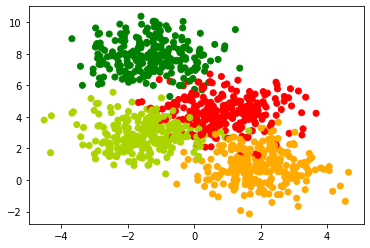

In [8]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [9]:
labels_orig = labels
labels = np.mod(labels_orig, 2)

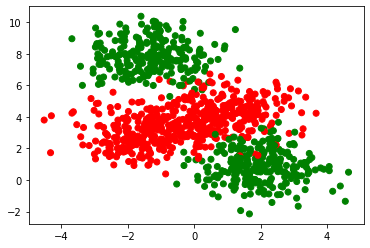

In [10]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [11]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify=labels, random_state=0)
print(X_train.shape, X_val.shape)

(750, 2) (250, 2)


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 62.08epoch/s]


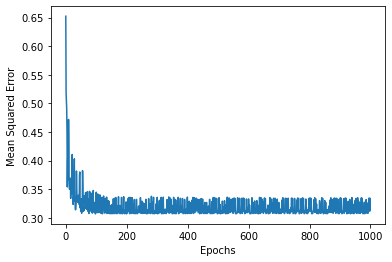

In [12]:
sn = SigmoidNeuron()
sn.fit(X_train, Y_train, epochs=1000, learning_rate=0.5, display_loss=True)

In [13]:
Y_pred_train = sn.predict(X_train)
Y_pred_binarised_train = (Y_pred_train >= 0.5).astype("int").ravel()
Y_pred_val = sn.predict(X_val)
Y_pred_binarised_val = (Y_pred_val >= 0.5).astype("int").ravel()
accuracy_train = accuracy_score(Y_pred_binarised_train, Y_train)
accuracy_val = accuracy_score(Y_pred_binarised_val, Y_val)

print("Training accuracy", round(accuracy_train, 2))
print("Validation accuracy", round(accuracy_val, 2))

Training accuracy 0.67
Validation accuracy 0.63


# MiniBatch 

100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 46.88epoch/s]


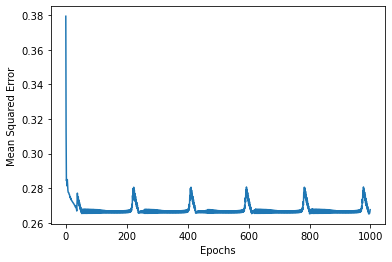

In [65]:
sn = SigmoidNeuron()
sn.fit(X_train, Y_train, epochs=1000, learning_rate=0.5, algo="MiniBatch", mini_batch_size=100, display_loss=True)

In [66]:
Y_pred_train = sn.predict(X_train)
Y_pred_binarised_train = (Y_pred_train >= 0.5).astype("int").ravel()
Y_pred_val = sn.predict(X_val)
Y_pred_binarised_val = (Y_pred_val >= 0.5).astype("int").ravel()
accuracy_train = accuracy_score(Y_pred_binarised_train, Y_train)
accuracy_val = accuracy_score(Y_pred_binarised_val, Y_val)

print("Training accuracy", round(accuracy_train, 2))
print("Validation accuracy", round(accuracy_val, 2))

Training accuracy 0.73
Validation accuracy 0.71


# Momentum

100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 46.96epoch/s]


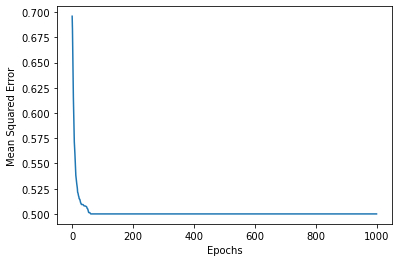

In [73]:
sn = SigmoidNeuron()
sn.fit(X_train, Y_train, epochs=1000, learning_rate=1.0, algo="Momentum", mini_batch_size=100, display_loss=True)

In [74]:
Y_pred_train = sn.predict(X_train)
Y_pred_binarised_train = (Y_pred_train >= 0.5).astype("int").ravel()
Y_pred_val = sn.predict(X_val)
Y_pred_binarised_val = (Y_pred_val >= 0.5).astype("int").ravel()
accuracy_train = accuracy_score(Y_pred_binarised_train, Y_train)
accuracy_val = accuracy_score(Y_pred_binarised_val, Y_val)

print("Training accuracy", round(accuracy_train, 2))
print("Validation accuracy", round(accuracy_val, 2))

Training accuracy 0.5
Validation accuracy 0.49


# NAG

100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.71epoch/s]


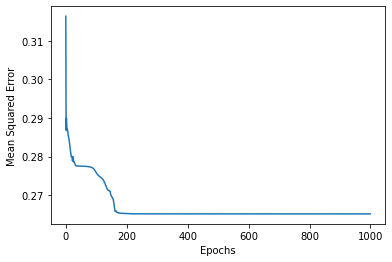

In [77]:
sn = SigmoidNeuron()
sn.fit(X_train, Y_train, epochs=1000, learning_rate=1.0, algo="NAG", mini_batch_size=100, display_loss=True)

In [78]:
Y_pred_train = sn.predict(X_train)
Y_pred_binarised_train = (Y_pred_train >= 0.5).astype("int").ravel()
Y_pred_val = sn.predict(X_val)
Y_pred_binarised_val = (Y_pred_val >= 0.5).astype("int").ravel()
accuracy_train = accuracy_score(Y_pred_binarised_train, Y_train)
accuracy_val = accuracy_score(Y_pred_binarised_val, Y_val)

print("Training accuracy", round(accuracy_train, 2))
print("Validation accuracy", round(accuracy_val, 2))

Training accuracy 0.73
Validation accuracy 0.72
